# Classification. Linear models and KNN

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [47]:
from sklearn.exceptions import NotFittedError
from numpy import linalg as LA

In [48]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your code>  
        sig = []
        for i in range(X.shape[0]):
            sig.append(1/(1+np.exp(-(weights.T @ X[i]))))
        return sig
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # <your code>
        x_w = []
        for i in range(x.shape[0]):
            x_w.append(np.sum(weights[1:] @ x[i]) + weights[0])
        log_los = []
        for i in range(len(y)):
            log_los.append(np.log(1+np.exp(-(x_w[i]*y[i]))))
        log_res_loss = np.mean(log_los) + 1/(2*self.C)*(LA.norm(weights)**2)
        return log_res_loss
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        loss_history =[]
        for i in range(self.max_iter):
            delta_sum = y*X_ext.T*(1-(1/(1 + np.exp(-(X_ext @ self.weights_)*y))))
            delta =1/len(y)*delta_sum.sum(axis = 1) - (1/self.C)*self.weights_
            self.weights_ += self.eta * delta
            loss_history.append(self.get_loss(X, self.weights_, y))
            if LA.norm(delta * self.eta)< self.tol:
                break
        self.loss_history = loss_history

     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        y_pred = []
        for i in range(len(self.predict_proba(X))):
            if self.predict_proba(X)[i] > 0.5:
                y_pred.append(1)
            else:
                y_pred.append(-1)
        return y_pred

In [49]:
from sklearn import datasets
from sklearn import metrics

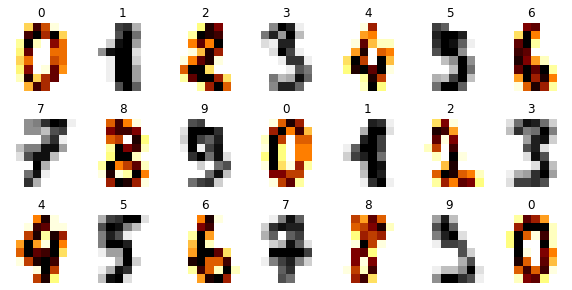

In [50]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [51]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [52]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [53]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [54]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [55]:
lr_clf.fit(X_train, y_train)

In [56]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [57]:
model = CustomLogisticRegression()

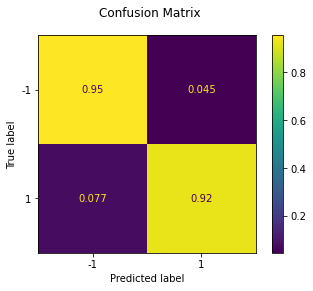

In [425]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [426]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [427]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

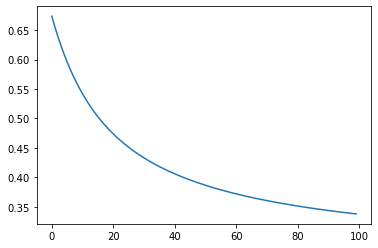

In [431]:
## your code
my_model = CustomLogisticRegression(max_iter=100, zero_init=True)
my_model.fit(X_train, y_train)
loss_history = my_model.loss_history 
loss_history
x = np.arange(100)
plt.plot(x, loss_history, label='loss')

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

Text(0.5, 1.0, 'loss with bigger eta')

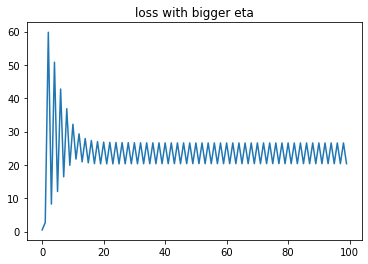

In [459]:
## your code
my_model_2 = CustomLogisticRegression(eta=0.1, max_iter=100, zero_init=True)
my_model_2.fit(X_train, y_train)
loss_history = my_model_2.loss_history 
loss_history
x = np.arange(100)
plt.plot(x, loss_history)
plt.title('loss with bigger eta')

Text(0.5, 1.0, 'loss with small eta')

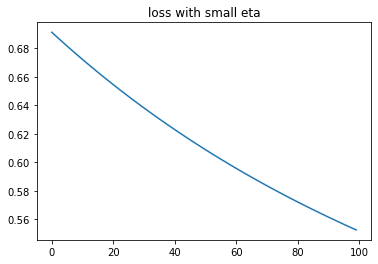

In [458]:
my_model_3 = CustomLogisticRegression(eta=0.0001, max_iter=100, zero_init=True)
my_model_3.fit(X_train, y_train)
loss_history = my_model_3.loss_history 
loss_history
x = np.arange(100)
plt.plot(x, loss_history)
plt.title('loss with small eta')

< your thoughts > learning rates  подобран "оптимально". И большие и маленькие значения могут ухудшать сходимость.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

Text(0.5, 1.0, 'loss with small C')

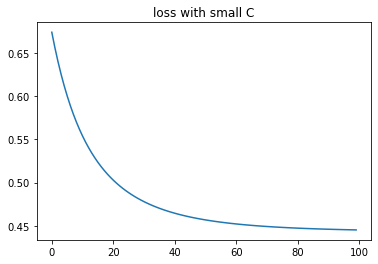

In [457]:
## your code
my_model_2 = CustomLogisticRegression(C=0.1, max_iter=100, zero_init=True)
my_model_2.fit(X_train, y_train)
loss_history = my_model_2.loss_history 
loss_history
x = np.arange(100)
plt.plot(x, loss_history)
plt.title('loss with small C')

Text(0.5, 1.0, 'loss with big C')

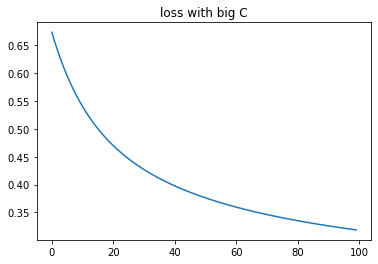

In [456]:
my_model_3 = CustomLogisticRegression(C=100.0, max_iter=100, zero_init=True)
my_model_3.fit(X_train, y_train)
loss_history = my_model_3.loss_history 
loss_history
x = np.arange(100)
plt.plot(x, loss_history)
plt.title('loss with big C')

< your thoughts > уменьшение параметра С ухудшает модель. При его увеличении особых изменений не замечено.

**(0.5 points)** Compare zero initialization and random initialization. 

Text(0.5, 1.0, 'loss with zero init')

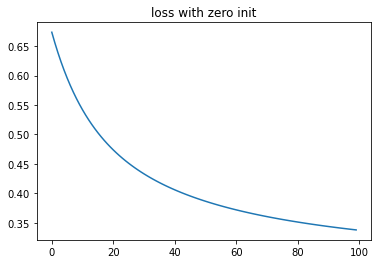

In [455]:
## your code
my_model = CustomLogisticRegression(max_iter=100, zero_init=True)
my_model.fit(X_train, y_train)
loss_history = my_model.loss_history 
loss_history
x = np.arange(100)
plt.plot(x, loss_history)
plt.title('loss with zero init')

Text(0.5, 1.0, 'loss with random init')

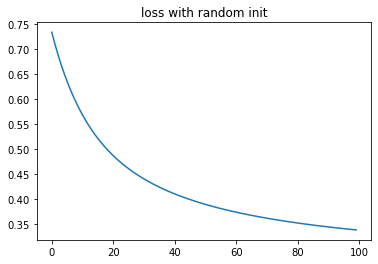

In [453]:
my_model = CustomLogisticRegression(max_iter=100, zero_init=False)
my_model.fit(X_train, y_train)
loss_history = my_model.loss_history 
loss_history
x = np.arange(100)
plt.plot(x, loss_history)
plt.title('loss with random init')

< your thoughts > При рандомной инициализации ошибка не первых итерациях несколько выше. Однако на сходимости это существенно не сказывается.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [197]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        # <your code>
        distances = np.empty([X.shape[0],Y.shape[0]])
        for i in range(X.shape[0]):
            for j in range(Y.shape[0]):
                distances[i,j] = LA.norm(X[i] - Y[j])
        return distances
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        # <your code>
        weight_cl = np.zeros(len(self.classes_))
        for i in range(len(y)):
            ind_el_cl = list(self.classes_).index(y[i])
            weight_cl[ind_el_cl] += weights[i]  
        return weight_cl
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            #print(self.points, 'points')
            P = self.get_pairwise_distances(X, self.points)
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1/(P+self.eps)
            y = np.array([[]])
            for i in range(X.shape[0]):
                weights_sample = pd.DataFrame(zip(self.y, weights_of_points[i]), columns=['class', 'weights_sample'])
                weights_sample = weights_sample.sort_values(by='weights_sample', ascending=False).head(self.n_neighbors)
                weight_cl = self.get_class_weights(weights_sample['class'].values, weights_sample['weights_sample'].values)
                y=np.append(y, weight_cl/(np.sum(weight_cl)))          
            return y.reshape(X.shape[0], len(self.classes_))
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
        
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        class_lab =[]
        probab = self.predict_proba(X)
        for i in range(probab.shape[0]):
            ind_class = probab[i].tolist().index(np.max(probab[i]))
            class_lab.append(self.classes_[ind_class])
        return class_lab

In [198]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [199]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [200]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

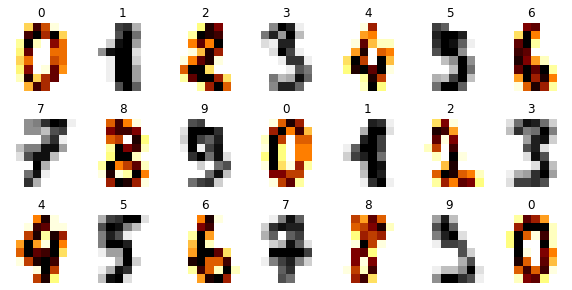

In [201]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [202]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [196]:
model.predict_proba(X_test[0:1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] zero weight
[0.        0.        0.        0.        0.        0.        0.3002786
 0.        0.        0.       ] return weight
[0.        0.        0.        0.        0.        0.        0.3002786
 0.        0.        0.       ] weight_cl


array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

In [203]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

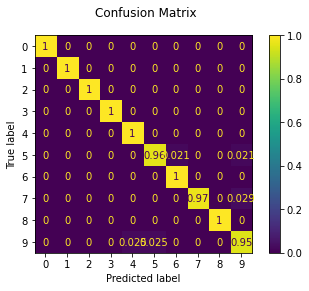

In [204]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [205]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts >

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

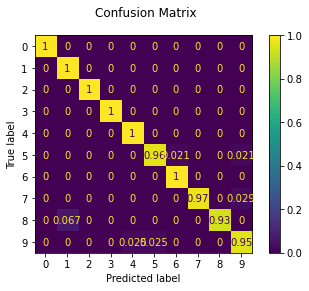

In [206]:
## your code
model_my = CustomKNeighborsClassifier(n_neighbors=10, weights='distance')
model_my.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model_my, X_train, y_train, X_test, y_test)

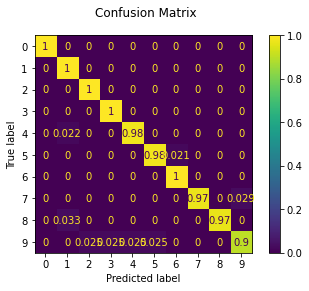

In [657]:
model_my2 = CustomKNeighborsClassifier(n_neighbors=2, weights='distance')
model_my2.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model_my2, X_train, y_train, X_test, y_test)

< your thoughts > уменьшение количества соседей до 2 ухудшило модель, увеличение до 10 существенного влияния не оказало.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

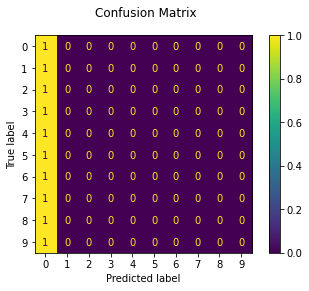

In [207]:
## your code
model_my = CustomKNeighborsClassifier(n_neighbors=10, weights= 'uniform')
model_my.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model_my, X_train, y_train, X_test, y_test)

< your thoughts >

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts > все расстояния Lp c p принадлежащем [0,+infty] можно пробовать. 

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts > 

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [8]:
#PATH = "./data/"
PATH = ""

In [9]:
#data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
data = pd.read_csv(os.path.join(PATH, 'train.csv')).set_index('PassengerId')

In [10]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [18]:
## your code
male = data[data['Sex'] == 'male'].shape[0]
female = data[data['Sex'] == 'female'].shape[0]
print(f'количество мужчин {male}, количество женщин {female}')

количество мужчин 56114, количество женщин 43886


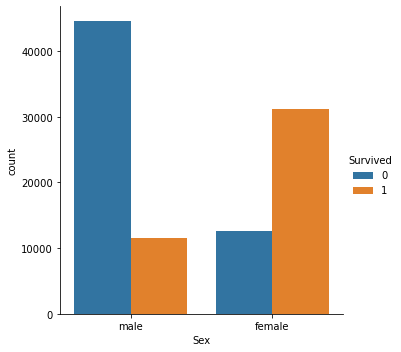

In [19]:
sns.catplot(x ='Sex', data = data, hue = 'Survived', kind = 'count')

< your thoughts > женщины выживали гораздо чаще чем мужчины: приблизительно только 1/4 мужчин выжили, в тоже время  около 2/3 женщин выжили. Видимо спасали прежде всего женщин.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

 средний возраст пассажиров 38.35547214294576 
 медиана возраста 39.0
 среднеквадратичное отклонение 18.313555719374882


<AxesSubplot:xlabel='Age', ylabel='Count'>

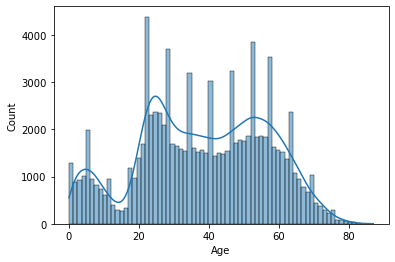

In [20]:
## your code
#найдём меры центральной тенденции и изобразим респределение даных возраста всех пассажиров (выживших и погибших)
mean_age = data['Age'].mean()
median_age = data['Age'].median()
std_age = data['Age'].std()
print(f' средний возраст пассажиров {mean_age} \
\n медиана возраста {median_age}\
\n среднеквадратичное отклонение {std_age}')
sns.histplot(data['Age'], kde = True)

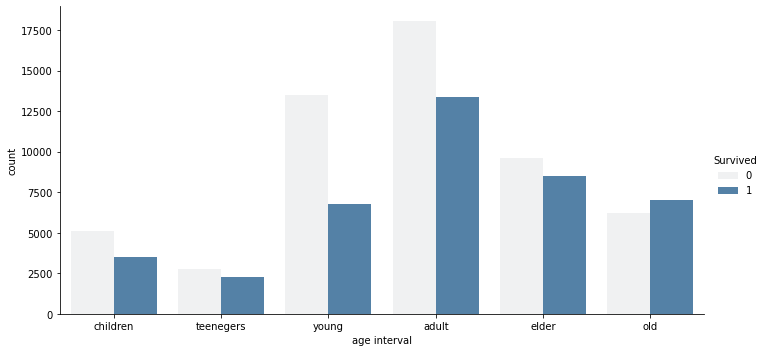

In [22]:
# для наглядности отобразим по возрастным группам выживших и погибших пассажиров
data['age interval'] = pd.cut(data['Age'], bins=[0.08,10,20,30,50,60, 87],\
                                    labels=['children','teenegers','young', 'adult', 'elder', 'old'], right = False)
sns.catplot(x = "age interval", data=data, aspect=2, kind="count", hue = 'Survived', color='steelblue')

 средний возраст выживших пассажиров 40.55379931430776 
 медиана возраста выживших 43.0
 среднеквадратичное отклонение выживших 18.742171554427923


<AxesSubplot:xlabel='Age', ylabel='Count'>

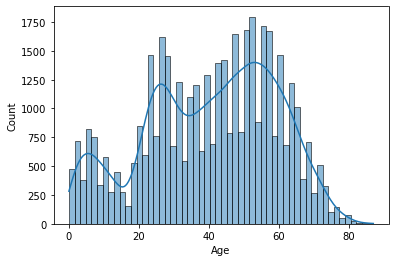

In [29]:
# рассмотрим меры центральной тенденции и распределение возраста выживших пассажиров
survived_ps = data[data['Survived'] == 1]
mean_age_surv = survived_ps['Age'].mean()
median_age_surv = survived_ps['Age'].median()
std_age_surv = survived_ps['Age'].std()
print(f' средний возраст выживших пассажиров {mean_age_surv} \
\n медиана возраста выживших {median_age_surv}\
\n среднеквадратичное отклонение выживших {std_age_surv}')
sns.histplot(survived_ps['Age'], kde = True)

 средний возраст погибших пассажиров 36.708694881533724 
 медиана возраста погибших 36.0
 среднеквадратичное отклонение погибших 17.80905758197035


<AxesSubplot:xlabel='Age', ylabel='Count'>

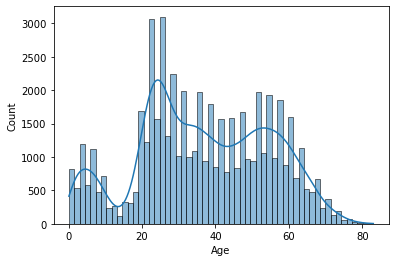

In [31]:
# рассмотрим меры центральной тенденции и распределение возраста погибших пассажиров
deceased_ps = data[data['Survived'] == 0]
mean_age_dec = deceased_ps['Age'].mean()
median_age_dec = deceased_ps['Age'].median()
std_age_dec = deceased_ps['Age'].std()
print(f' средний возраст погибших пассажиров {mean_age_dec} \
\n медиана возраста погибших {median_age_dec}\
\n среднеквадратичное отклонение погибших {std_age_dec}')
sns.histplot(deceased_ps['Age'], kde = True)

< your thoughts > Среди молодых было больше погибших. Возможно спасали в первую очередь более возрастных.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

<AxesSubplot:xlabel='Embarked', ylabel='count'>

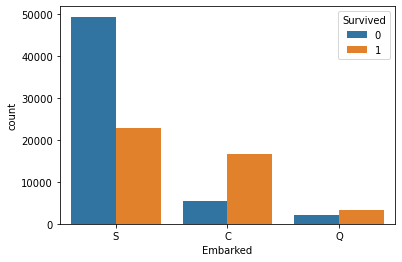

In [32]:
## your code
sns.countplot(x='Embarked', hue = 'Survived', data = data)

<AxesSubplot:xlabel='Pclass', ylabel='count'>

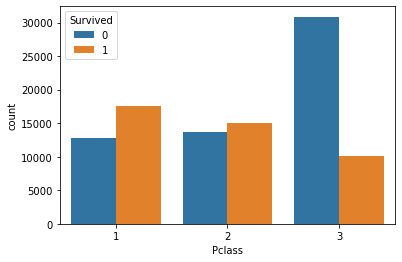

In [36]:
sns.countplot(x='Pclass', hue = 'Survived', data = data)

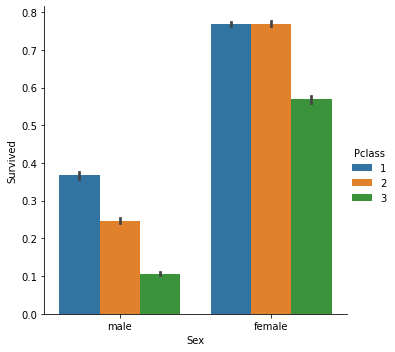

In [34]:
sns.catplot(kind="bar", x="Sex", y="Survived", hue="Pclass", data=data)

< your thoughts > Наибольшее количество погибших пассажиров среди пассажиров 3 класса.  Среди погибших в зависимости от места отправления наибольшее количество отпрвлялось из S.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [38]:
## your code
data.isnull().sum()/data.count()

Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age             0.034041
SibSp           0.000000
Parch           0.000000
Ticket          0.048471
Fare            0.001342
Cabin           2.111969
Embarked        0.002506
age interval    0.034051
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts > Некоторые столбцы на мой стоит просто удалить, например номер билета и кабины, так как они вряд ли будут сильно информативны для наших исследований. В категориальных переменных пропущенные данные можно заполнить "unknown", чтобы не увеличивать ни одно из значений категориальной переменной и не искажать статистику. Пропущенные данные для количественных переменных можно заполнить медианой. 

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [80]:
## your code
## Удалим столбцы с большим количеством пропусков и не содержащие ценной для наших исследований информации
useless_columns = ['Name', 'Ticket', 'Cabin']
train = data.drop(columns = useless_columns)

In [81]:
# inputting - заполнение пропущенных значений

def impute_data(df):
    df_copy = df.copy() # копируем, чтобы не изменять оригинал
    
    # заполняем пропущенные данные для категориальных переменных
    categorical_vars = list(df_copy.select_dtypes(include=['object']).columns.values)
    for col in categorical_vars:# можно рассмореть только столбец 'Embarked', так как других столбцов с пропущенными категориальными переменными нет
        if (df_copy[col].isnull().values.any()):
            df_copy[col].fillna('unknown', inplace = True)# заполняем пропущенные данные "unknown", чтобы не увеличивать ни одно из значений категориальной переменной и не искажать статистику
            
    
    # заполняем пропущенные данные для количественных переменных
    numerical_vars = list(df_copy.select_dtypes(include=['int64', 'float64']).columns.values)
    for col in numerical_vars:
        if (df_copy[col].isnull().values.any()):
            df_copy[col].fillna(df_copy[col].median(), inplace = True) # заполняем пропуски медианой
    
    
    return df_copy

train_full = impute_data(train)
train_full

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,age interval
PassengerId,,,,,,,,,
0,1,1,male,39.00,2,0,27.14,S,NaN
1,0,3,male,39.00,0,0,13.35,S,NaN
2,0,3,male,0.33,1,2,71.29,S,children
3,0,3,male,19.00,0,0,13.04,S,teenegers
4,1,3,male,25.00,0,0,7.76,S,young
...,...,...,...,...,...,...,...,...,...
99995,1,2,female,62.00,0,0,14.86,C,old
99996,0,2,male,66.00,0,0,11.15,S,old
99997,0,3,male,37.00,0,0,9.95,S,adult


In [84]:
#data[data['Sex'] == 'male']
train_full.loc[train_full['Sex'] == 'male', 'Sex'] =1
train_full.loc[train_full['Sex'] == 'female', 'Sex'] =0

In [83]:
train_full

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,age interval
PassengerId,,,,,,,,,
0,1,1,1,39.00,2,0,27.14,S,NaN
1,0,3,1,39.00,0,0,13.35,S,NaN
2,0,3,1,0.33,1,2,71.29,S,children
3,0,3,1,19.00,0,0,13.04,S,teenegers
4,1,3,1,25.00,0,0,7.76,S,young
...,...,...,...,...,...,...,...,...,...
99995,1,2,female,62.00,0,0,14.86,C,old
99996,0,2,1,66.00,0,0,11.15,S,old
99997,0,3,1,37.00,0,0,9.95,S,adult


In [85]:
target = 'Survived'
features = ['Pclass', 'Sex', 'Age']
X = train_full[features]
y = train_full[target]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
X_train

,Pclass,Sex,Age
PassengerId,,,
76513,2,1,18.0
60406,1,0,36.0
27322,1,1,52.0
53699,3,1,25.0
65412,1,1,25.0
...,...,...,...
6265,2,1,19.0
54886,2,1,43.0
76820,1,0,46.0


In [91]:
from sklearn.linear_model import LogisticRegression

In [156]:
modelLogReg = LogisticRegression()
#results = cross_validate(modelLogReg, X, y, cv=5,
                             #return_train_score=True,
                             #scoring='neg_root_mean_squared_error')
modelLogReg.fit(X_train, y_train)
metrics.accuracy_score(y_pred=modelLogReg.predict(X_train), y_true=y_train)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


1.0

In [87]:
modelKNN = KNeighborsClassifier(n_neighbors=5, weights='distance')
modelKNN.fit(X_train, y_train)
metrics.accuracy_score(y_pred=modelKNN.predict(X_train), y_true=y_train)

0.7304

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [98]:
## your code
data_test = pd.read_csv(os.path.join(PATH, 'test.csv')).set_index('PassengerId')
data_test.loc[data_test['Sex'] == 'male', 'Sex'] =1
data_test.loc[data_test['Sex'] == 'female', 'Sex'] =0
data_test

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
100000,3,"Holliday, Daniel",1,19.0,0,0,24745,63.01,NaN,S
100001,3,"Nguyen, Lorraine",0,53.0,0,0,13264,5.81,NaN,S
100002,1,"Harris, Heather",0,19.0,0,0,25990,38.91,B15315,C
100003,2,"Larsen, Eric",1,25.0,0,0,314011,12.93,NaN,S
100004,1,"Cleary, Sarah",0,17.0,0,2,26203,26.89,B22515,C
...,...,...,...,...,...,...,...,...,...,...
199995,3,"Cash, Cheryle",0,27.0,0,0,7686,10.12,NaN,Q
199996,1,"Brown, Howard",1,59.0,1,0,13004,68.31,NaN,S
199997,3,"Lightfoot, Cameron",1,47.0,0,0,4383317,10.87,NaN,S


In [102]:
data_test.isnull().sum()

Pclass          0
Name            0
Sex             0
Age          3487
SibSp           0
Parch           0
Ticket       5181
Fare          133
Cabin       70831
Embarked      277
dtype: int64

In [103]:
train_full_test = impute_data(data_test)

In [105]:
X_test = train_full_test[features]
X_test

,Pclass,Sex,Age
PassengerId,,,
100000,3,1,19.0
100001,3,0,53.0
100002,1,0,19.0
100003,2,1,25.0
100004,1,0,17.0
...,...,...,...
199995,3,0,27.0
199996,1,1,59.0
199997,3,1,47.0


In [111]:
X_test.index

Int64Index([100000, 100001, 100002, 100003, 100004, 100005, 100006, 100007,
            100008, 100009,
            ...
            199990, 199991, 199992, 199993, 199994, 199995, 199996, 199997,
            199998, 199999],
           dtype='int64', name='PassengerId', length=100000)

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [113]:
y_pred = modelKNN.predict(X_test)

In [129]:
df = pd.DataFrame({'PassengerId':X_test.index, 'Survived':y_pred})
df.set_index('PassengerId', inplace=True)
df.to_csv(r'testResult.csv')